# Chapter 5: Support Vector Machines

In [1]:
import joblib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import loguniform, uniform

from sklearn.compose import TransformedTargetRegressor
from sklearn.datasets import fetch_california_housing, load_iris, load_wine
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    RandomizedSearchCV,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC, SVR

1. For **classification** the fundamental idea behind an SVM is: to fit the widest possible *street*, meaning a decision boundary that is far as possible from the training instances while limiting the number of *margin violations* (e.g. misclassified training instances). For **regression**, an SVM tries to fit as many training instances as possible *onto* the street (whose size is controlled by a model hyperparameter), while minimizing the number of margin violations (instances *off* the street).
2. For SVM classification, a support vector is a vector on the edge of the street (since adding more training instances off the street does not alter the model). For SVM regression, the support vectors are the instances off the street as additional instances on the street do not affect the model.
3. Since an SVM is trying to fit the widest possible street, it will neglect smaller features, so it is best to scale features.
4. The confidence score is given by the `decision_function()` method and returns the signed distance of the instance from the decision boundary. This can be converted to a probability using 5-fold cross-validation by setting the `probability` hyperparameter to `True`.
5. `LinearSVC`, `SVC`, and `SGDClassifier` (by default) all perform large margin classification. `LinearSVC` and `SGDClassifies` both have training complexities of $O(m \times n)$ so are good for large datasets. `SGDClassifier` uses stochastic gradient descent, so its good if incremental learning is required. `SVC` supports the kernel trick, so is good for non-linear data, however, this comes at the cost of complexity (which is up to $O(m^3 \times n)$).
6. If an SVM classifier with RBF kernel is underfitting, you should increase $\gamma$ (`gamma`) and/or `C`.
7. The street of an SVM regressor is controlled by hyperparameter $\epsilon$. Adding more training instances onto the street (of width $\epsilon$) has no effect on the model, therefore the model is called $\epsilon\text{-}insensitive$.
8. Using the kernel trick gives the same results as adding many polynomial or gaussian similarity features to your dataset but at a far greater computational efficiency.

## 9. Comparing `LinearSVC`, `SVC`, & `SGDClassifier`

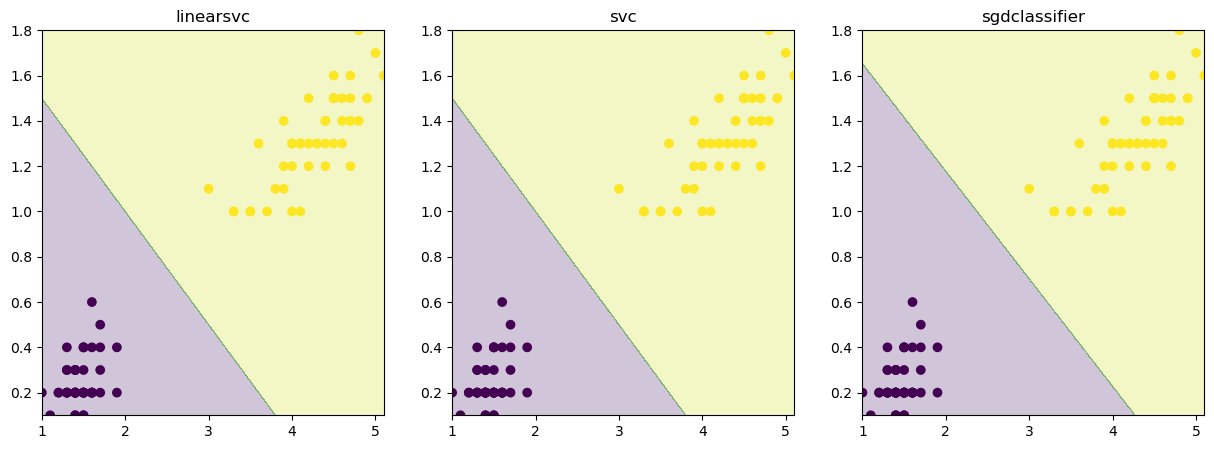

In [2]:
iris = load_iris(as_frame=True)
mask = iris["target"] != 2

X = iris.data[["petal length (cm)", "petal width (cm)"]].values[mask]
y = iris["target"].values[mask]

linear_svc = make_pipeline(
    MinMaxScaler(),
    LinearSVC(dual=True, loss="hinge", C=5, max_iter=10_000),
)
svc = make_pipeline(MinMaxScaler(), SVC(kernel="linear", C=5))
sgd = make_pipeline(MinMaxScaler(), SGDClassifier(alpha=0.01))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate([linear_svc, svc, sgd]):
    model.fit(X, y)

    x0, x1 = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), 1000),
        np.linspace(X[:, 1].min(), X[:, 1].max(), 1000),
    )
    z = model.predict(np.hstack((x0.reshape(-1, 1), x1.reshape(-1, 1))))
    axs[i].contourf(x0, x1, z.reshape(x0.shape), alpha=0.25)
    axs[i].scatter(X[:, 0], X[:, 1], c=y)
    axs[i].set_title(model.steps[-1][0])

plt.show()

## 10. SVM Classification of the wine dataset

In [3]:
X, y = load_wine(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = make_pipeline(
    SimpleImputer(),
    MinMaxScaler(),
    OneVsRestClassifier(LinearSVC(dual="auto")),
)

model.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test))

0.9777777777777777

## 11. SVM Regression on the California housing dataset

In [4]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


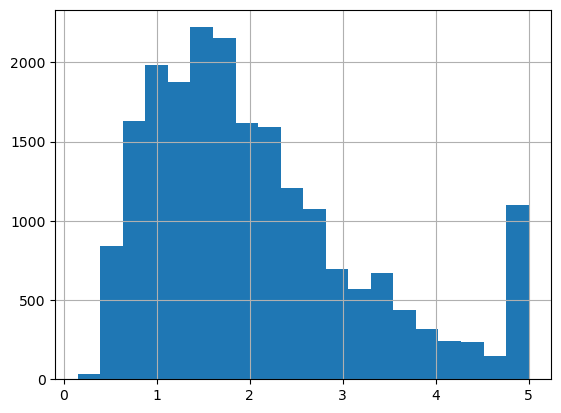

In [5]:
y.hist(bins=20)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=pd.cut(y, bins=4))

svr_model = make_pipeline(
    SimpleImputer(),
    MinMaxScaler(),
    TransformedTargetRegressor(SVR(), transformer=MinMaxScaler()),
)
svr_model.get_params()

{'memory': None,
 'steps': [('simpleimputer', SimpleImputer()),
  ('minmaxscaler', MinMaxScaler()),
  ('transformedtargetregressor',
   TransformedTargetRegressor(regressor=SVR(), transformer=MinMaxScaler()))],
 'verbose': False,
 'simpleimputer': SimpleImputer(),
 'minmaxscaler': MinMaxScaler(),
 'transformedtargetregressor': TransformedTargetRegressor(regressor=SVR(), transformer=MinMaxScaler()),
 'simpleimputer__add_indicator': False,
 'simpleimputer__copy': True,
 'simpleimputer__fill_value': None,
 'simpleimputer__keep_empty_features': False,
 'simpleimputer__missing_values': nan,
 'simpleimputer__strategy': 'mean',
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'transformedtargetregressor__check_inverse': True,
 'transformedtargetregressor__func': None,
 'transformedtargetregressor__inverse_func': None,
 'transformedtargetregressor__regressor__C': 1.0,
 'transformedtargetregressor__regressor__cache_size': 200,
 'transformedtarg

In [7]:
param_distributions = {
    "transformedtargetregressor__regressor__kernel": ["rbf"],
    "transformedtargetregressor__regressor__gamma": loguniform(0.1, 100),
    "transformedtargetregressor__regressor__C": uniform(0, 100),
}

rndm_search_cv = RandomizedSearchCV(
    svr_model,
    param_distributions,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
)

In [8]:
model_name = "05_svr_california_housing_model"
model_path = Path(f"models/{model_name}.pkl")
if model_path.is_file():
    rndm_search_cv = joblib.load(model_path)
else:
    rndm_search_cv.fit(X_train, y_train)
    joblib.dump(rndm_search_cv, model_path)

In [9]:
rndm_search_cv.best_params_

{'transformedtargetregressor__regressor__C': 22.2038950497782,
 'transformedtargetregressor__regressor__gamma': 11.833163375329434,
 'transformedtargetregressor__regressor__kernel': 'rbf'}

In [10]:
-rndm_search_cv.best_score_

0.590006438185519

In [11]:
-cross_val_score(
    rndm_search_cv.best_estimator_,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
).mean()

0.599916634966369

In [12]:
rndm_search_cv.best_estimator_.fit(X_train, y_train)
mean_squared_error(y_test, rndm_search_cv.predict(X_test), squared=False)

0.5880435554393856